<a href="https://colab.research.google.com/github/pavlo-seimskyi/nyc-taxi-data/blob/main/EDA_and_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
%%capture
!pip install fastai --upgrade
!pip install dtreeviz
!pip install fastbook
!pip install utils
!pip install treeinterpreter
!pip install waterfallcharts

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from fastbook import *
import shutil
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from fastai.vision import *
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from utils import *

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 17)
pd.set_option('float_format', '{:f}'.format)

# Load the data

## Raw data analysis

In [4]:
if not os.path.exists('taxi_test') :
  os.mkdir('taxi_test')

In [5]:
Path.BASE_PATH = Path('taxi_test')

From the site directly

In [6]:
# Retrieve the data from the NYC.gov website (this will take roughly 5 minutes)
urls = ['https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-03.csv', 
        'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-06.csv',
        'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-11.csv']

df = pd.DataFrame()

# Load csv file one by one and concatenate into one big csv
for url in urls :
  print('Loading ', url.split('/')[-1], '...')
  df_new = pd.read_csv(url, low_memory=True)
  df = pd.concat([df, df_new])

Loading  yellow_tripdata_2017-03.csv ...
Loading  yellow_tripdata_2017-06.csv ...
Loading  yellow_tripdata_2017-11.csv ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29236424 entries, 0 to 9284802
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   RatecodeID             int64  
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
dtypes: float64(8), int64(6), object(3)
memory usage: 3.9+ GB


In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.060000,1,N,148,48,1,14.000000,0.500000,0.500000,3.060000,0.000000,0.300000,18.360000
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.730000,1,N,48,107,2,11.500000,0.500000,0.500000,0.000000,0.000000,0.300000,12.800000
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.270000,1,N,79,162,1,10.000000,0.500000,0.500000,2.820000,0.000000,0.300000,14.120000
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.860000,1,N,237,41,1,12.000000,0.500000,0.500000,3.990000,0.000000,0.300000,17.290000
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.450000,1,N,41,162,2,12.000000,0.500000,0.500000,0.000000,0.000000,0.300000,13.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284798,2,2017-11-30 23:27:24,2017-11-30 23:48:15,1,3.160000,1,N,90,141,1,15.000000,0.500000,0.500000,2.700000,0.000000,0.300000,19.000000
9284799,1,2017-11-30 23:59:05,2017-11-30 23:59:14,1,0.000000,1,N,25,25,2,2.500000,0.500000,0.500000,0.000000,0.000000,0.300000,3.800000
9284800,2,2017-11-30 23:17:20,2017-11-30 23:39:33,1,10.280000,1,N,161,127,1,30.000000,0.500000,0.500000,6.260000,0.000000,0.300000,37.560000
9284801,2,2017-11-30 22:52:40,2017-11-30 23:27:26,1,5.800000,1,N,113,181,1,24.500000,0.500000,0.500000,5.160000,0.000000,0.300000,30.960000


How many rows x columns do we have here?

In [9]:
df.shape

(29236424, 17)

Check for missing values


In [10]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

What was the highest price?

In [13]:
highest_fare = df[df.total_amount == df.total_amount.max()]
highest_fare

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
5773420,1,2017-06-20 22:34:58,2017-06-20 22:39:16,1,0.800000,1,N,141,141,2,630461.820000,0.500000,0.500000,0.000000,0.000000,0.300000,630463.120000


Ride price of $630,000 and `trip_distance` of 0.8? This surely has to be a mistake.

In [16]:
df.groupby('VendorID').total_amount.describe()

,count,mean,std,min,25%,50%,75%,max
VendorID,,,,,,,,
1,13276147.000000,16.232723,218.265102,0.000000,8.500000,11.800000,17.800000,630463.120000
2,15960277.000000,16.625425,15.463739,-550.300000,8.760000,11.840000,18.300000,9999.990000


Looks like these mistakes happen mainly with vendor 1, "Creative Mobile Technologies". For our example company, I would advise choosing the second company for cleaner data.

### Find the outliers

In [18]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000,29236424.000000
mean,1.545904,1.617798,2.919386,1.043350,163.202353,161.190994,1.329500,13.109297,0.333941,0.497310,1.874055,0.329011,0.299628,16.447101
std,0.497888,1.260992,4.476535,0.509511,66.614169,70.478191,0.490347,147.281670,0.461574,0.070817,2.645570,1.968881,0.014089,147.524780
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-550.000000,-53.710000,-0.500000,-112.000000,-17.500000,-0.300000,-550.300000
25%,1.000000,1.000000,0.970000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,2.000000,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.360000,0.000000,0.300000,11.800000
75%,2.000000,2.000000,3.010000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.460000,0.000000,0.300000,17.800000
max,2.000000,192.000000,9496.980000,99.000000,265.000000,265.000000,5.000000,630461.820000,69.800000,140.000000,450.000000,1018.950000,1.000000,630463.120000


#### Price (`total_amount`)

In [19]:
price_min_threshold = df['total_amount'].quantile(0.001)
price_max_threshold =  df['total_amount'].quantile(0.999)
price_min_threshold, price_max_threshold

(3.3, 114.46)

In [20]:
df[df['total_amount'] > price_max_threshold]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
159,1,2017-03-01 00:00:52,2017-03-01 00:02:00,1,0.100000,5,N,265,265,1,110.000000,0.000000,0.000000,22.050000,0.000000,0.300000,132.350000
3667,1,2017-03-10 14:21:25,2017-03-10 15:23:17,1,37.600000,3,N,132,1,1,116.000000,0.000000,0.000000,10.000000,26.580000,0.300000,152.880000
4832,2,2017-03-10 14:25:25,2017-03-10 15:23:32,1,27.910000,5,N,194,1,1,110.000000,0.000000,0.500000,20.000000,16.040000,0.300000,146.840000
4900,1,2017-03-10 14:25:40,2017-03-10 14:25:40,0,0.000000,99,N,264,264,1,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117.000000
5186,2,2017-03-10 14:26:39,2017-03-10 15:18:11,1,21.460000,3,N,161,1,1,82.000000,0.000000,0.000000,19.880000,17.100000,0.300000,119.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9279063,1,2017-11-30 23:11:50,2017-11-30 23:58:55,1,25.900000,5,N,132,265,1,99.000000,0.000000,0.000000,23.100000,16.260000,0.300000,138.660000
9282821,1,2017-11-30 23:04:07,2017-12-01 00:22:47,1,49.000000,5,N,132,265,1,150.000000,0.000000,0.000000,140.000000,11.520000,0.300000,301.820000
9283598,1,2017-11-30 23:29:32,2017-11-30 23:59:02,2,29.700000,5,N,265,265,2,120.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.300000
9283698,2,2017-11-30 23:42:38,2017-12-01 00:24:42,1,27.380000,5,N,48,265,1,100.000000,0.000000,0.500000,12.500000,10.500000,0.300000,123.800000


In [21]:
print(f'There were {df[df["total_amount"] < price_min_threshold].shape[0] + df[df["total_amount"] > price_max_threshold].shape[0]} outliers in total in terms of price.')

There were 55767 outliers in total in terms of price.


#### Number of passengers (`passenger_count`)

In [22]:
df.passenger_count.unique()

array([  1,   2,   5,   3,   4,   6,   0,   9,   8,   7, 192])

192? Probably, input by accident by the driver. Let's look at this row.

In [23]:
df[df.passenger_count == 192]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
8843697,2,2017-11-29 18:49:11,2017-11-29 18:55:47,192,1.070000,1,N,158,68,1,6.500000,1.000000,0.500000,1.240000,0.000000,0.300000,9.540000


In [24]:
passenger_min_threshold = 1 # we will remove all the rows that have less than 1 passenger
passenger_max_threshold = 10 # will remove all the rows that have above 10
passenger_min_threshold, passenger_max_threshold

(1, 10)

In [25]:
print(f'There were {df[df["passenger_count"] < 1].shape[0] + df[df["passenger_count"] > 9].shape[0]} outliers in terms of passenger count (below 1 or above 9). Since the number gets input by the drivers, they probably forgot.')

There were 51761 outliers in terms of passenger count (below 1 or above 9). Since the number gets input by the drivers, they probably forgot.


#### RatecodeID

In [26]:
print(f'There were {df[df["RatecodeID"] > 6].shape[0]} rides with rate code more than 6 and {df[df["RatecodeID"] < 1].shape[0]} with rate code less than 1. These have to be mistakes.')

There were 524 rides with rate code more than 6 and 0 with rate code less than 1. These have to be mistakes.


#### Trip distance

In [27]:
trip_min_threshold = df.trip_distance.quantile(0.001)
trip_max_threshold = df.trip_distance.quantile(0.999)
trip_min_threshold, trip_max_threshold

(0.0, 26.0)

In [28]:
print(f'There were {df[df["trip_distance"] < trip_min_threshold].shape[0] + df[df["trip_distance"] > trip_max_threshold].shape[0]} outliers in total in terms of price.')

There were 29150 outliers in total in terms of price.


#### Time spent

In [29]:
# time_min_threshold = df.min_spent.quantile(0.001)
# time_max_threshold = df.min_spent.quantile(0.999)
# time_min_threshold, time_max_threshold

In [30]:
# print(f'There were {df[df["min_spent"] < time_min_threshold].shape[0] + df[df["min_spent"] > time_max_threshold].shape[0]} outliers in total in terms of time spent in a ride.')

#### Summary

In [32]:
print(f'''
There were...\n
{df[df["passenger_count"] < 1].shape[0] + df[df["passenger_count"] > 9].shape[0]} outliers in terms of passenger count (below 1 or above 9). Since the number gets input by the drivers which explains the mistakes.
{df[df["total_amount"] < price_min_threshold].shape[0] + df[df["total_amount"] > price_max_threshold].shape[0]} outliers in terms of price.
{df[df["RatecodeID"] > 6].shape[0]} rides with rate code more than 6 and {df[df["RatecodeID"] < 1].shape[0]} with rate code less than 1. These have to be mistakes.
{df[df["trip_distance"] < trip_min_threshold].shape[0] + df[df["trip_distance"] > trip_max_threshold].shape[0]} outliers in terms of trip distance.\n
In total up to {df[df["passenger_count"] < 1].shape[0] + df[df["passenger_count"] > 9].shape[0] +
                df[df["total_amount"] < price_min_threshold].shape[0] + df[df["total_amount"] > price_max_threshold].shape[0] + 
                df[df["RatecodeID"] > 6].shape[0] + df[df["RatecodeID"] < 1].shape[0] + 
                df[df["trip_distance"] < trip_min_threshold].shape[0] + df[df["trip_distance"] > trip_max_threshold].shape[0]} outliers in the data out of {df.shape[0]} samples.      
''')


There were...

51761 outliers in terms of passenger count (below 1 or above 9). Since the number gets input by the drivers which explains the mistakes.
55767 outliers in terms of price.
524 rides with rate code more than 6 and 0 with rate code less than 1. These have to be mistakes.
29150 outliers in terms of trip distance.

In total up to 137202 outliers in the data out of 29236424 samples.      



## Preprocessing & removing the outliers

We know now what steps to perform to clean the data. Since the data is too large and the machine crashes while preprocessing the whole file at once, we will need to preprocess it in chunks. [Guide article](https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c).

Two steps:
 
1. Feature engineering `min_spent` and `dayhour`
2. Remove the outliers
3. Change the datatypes to reduce memory load:
- `RateCodeID` only takes values from 1 to 6 - convert to `uint8`
- `Payment_type` only takes values from 1 to 6 - convert to `uint8`
- `VendorID` only takes values 1 or 2 - convert to `uint8`
- `Passenger_count` only takes values from 1 to 9 - convert to `uint8`
- `tpep_pickup_datetime` and `tpep_dropoff_datetime` are dates - convert to `datetime64[ns, US/Eastern]`

In [33]:
# first, save the whole file
if not os.path.exists('taxi_test/taxi_full_data.csv') :
  df.to_csv('taxi_test/taxi_full_data.csv', index=False)

In [ ]:
# copy from drive to local machine for faster loading
# if not os.path.exists('taxi_test/taxi_full_data.csv') :
#   !cp "drive/My Drive/fastai/taxi_test/taxi_full_data.csv" 'taxi_test'

In [4]:
# load the full data in chunks of 1,000,000 samples
df = pd.read_csv('taxi_test/taxi_full_data.csv', low_memory=True, chunksize=1000000)

In [5]:
# we will apply this function to round the time in hours to the nearest hour
def round_hours(n) : return math.floor(n + 0.5)

# preprocessing using the parameters found in the raw data
def preprocess_chunks(df) :

  # change the data types to reduce memory load
  df[['passenger_count', 'RatecodeID', 'payment_type']] = df[['passenger_count', 'RatecodeID', 'payment_type']].astype('int8')
  df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']] = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].astype('datetime64[ns]')
  df[['VendorID', 'PULocationID', 'DOLocationID', 'store_and_fwd_flag']] = df[['VendorID', 'PULocationID', 'DOLocationID', 'store_and_fwd_flag']].astype('category')

  # remove duplicate rows
  df.drop_duplicates()

  # feature engineering
  df.insert(3, "min_spent", (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).astype('timedelta64[m]').tolist(),
            allow_duplicates=True) # min_spent column
  df.insert(3, "time_hour", df.tpep_dropoff_datetime.tolist(), allow_duplicates=True)
  df['time_hour'] = df['time_hour'].dt.hour + df['time_hour'].dt.minute/60
  df['time_hour'] = df['time_hour'].apply(round_hours)
  df['min_spent'] = df['min_spent'].astype('int16')
  df['time_hour'] = df['time_hour'].astype('int8')

  # remove the outliers
  df = df[(df['total_amount'] > 3.3) & (df['total_amount'] < 114.46)] # in the price
  df = df[(df['passenger_count'] < 10) & (df['passenger_count'] >= 1)] # in passenger count
  df = df[(df["RatecodeID"] <= 6) & (df["RatecodeID"] >= 1)] # remove mistakes in rate codes
  df = df[(df['trip_distance'] > 0.0) & (df['trip_distance'] < 26.0)] # remove outliers in the trip distance
  df = df[(df['min_spent'] > 0.0) & (df['min_spent'] < 1419.0)] # remove outliers in the trip distance

  # replace 24 hours with 0 to remove duplicate values
  df.loc[(df['time_hour'] == 24),'time_hour'] = 0
  return df

Perform a test with a subset of data. Comment the cell below out to process the whole data.

In [ ]:
# df = df.sample(n=100000, random_state=41)

Process the whole data in chunks

In [6]:
chunk_list = []
for chunk in df:  
  df_new = preprocess_chunks(chunk)
  chunk_list.append(df_new)
df = pd.concat(chunk_list)

In [ ]:
# save the preprocessed file in drive for later reusage
# if not os.path.exists('drive/My Drive/fastai/taxi_test/taxi_preprocessed.csv') :
#   df.to_csv('drive/My Drive/fastai/taxi_test/taxi_preprocessed.csv', index=False)

In [7]:
df.describe()

,time_hour,min_spent,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000,28812526.000000
mean,14.226160,15.045092,1.622401,2.907827,1.029236,163.152304,161.081525,1.323972,12.893715,0.334541,0.498824,1.852645,0.313160,0.299983,16.196735
std,6.362527,34.822523,1.261267,3.594387,0.210846,66.552030,70.372665,0.483214,10.443147,0.454093,0.028185,2.414057,1.419857,0.002236,13.064783
min,0.000000,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.000000,-42.500000,0.000000,-0.080000,-5.760000,0.000000,3.350000
25%,10.000000,6.000000,1.000000,1.000000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,15.000000,11.000000,1.000000,1.630000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.400000,0.000000,0.300000,11.800000
75%,20.000000,18.000000,2.000000,3.030000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.460000,0.000000,0.300000,17.800000
max,24.000000,1418.000000,9.000000,25.990000,6.000000,265.000000,265.000000,5.000000,113.000000,69.800000,43.800000,112.000000,102.400000,0.300000,114.450000


In [8]:
df.info() # check for the file size and compare to after preprocessing

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28812526 entries, 0 to 29236423
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   time_hour              int8          
 4   min_spent              int16         
 5   passenger_count        int8          
 6   trip_distance          float64       
 7   RatecodeID             int8          
 8   store_and_fwd_flag     category      
 9   PULocationID           int64         
 10  DOLocationID           int64         
 11  payment_type           int8          
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

# Basic EDA

### Correlation matrix and heat map

Obtain the correlation coefficient matrix

In [114]:
corr = df.corr()
corr

,tpep_pickup_datetimeWeek,tpep_dropoff_datetimeWeek,time_hour,min_spent,passenger_count,trip_distance,RatecodeID,PULocationID,...,tpep_dropoff_datetimeDayofweek,tpep_dropoff_datetimeDayofyear,tpep_dropoff_datetimeIs_month_end,tpep_dropoff_datetimeIs_month_start,tpep_dropoff_datetimeIs_quarter_end,tpep_dropoff_datetimeIs_quarter_start,tpep_dropoff_datetimeIs_year_end,tpep_dropoff_datetimeIs_year_start
tpep_pickup_datetimeWeek,1.000000,0.999998,0.011236,0.012033,-0.001368,0.000028,0.000767,0.008275,...,-0.059227,0.999818,0.028553,-0.020150,-0.081117,-0.009084,-0.001757,-0.001757
tpep_dropoff_datetimeWeek,0.999998,1.000000,0.011125,0.012373,-0.001366,0.000099,0.000791,0.008268,...,-0.059317,0.999818,0.028542,-0.020161,-0.081125,-0.009085,-0.001757,-0.001757
time_hour,0.011236,0.011125,1.000000,0.003493,0.006852,-0.027554,0.001925,0.035814,...,-0.089671,0.009445,-0.001974,0.007286,-0.007136,-0.033444,-0.002097,-0.001944
min_spent,0.012033,0.012373,0.003493,1.000000,0.011528,0.287096,0.130618,-0.026277,...,-0.010296,0.012191,0.002765,0.002942,0.000228,0.037752,-0.000117,-0.000232
passenger_count,-0.001368,-0.001366,0.006852,0.011528,1.000000,0.014305,0.004789,-0.008016,...,0.023235,-0.000933,-0.001296,-0.004095,0.001343,0.000116,-0.000493,-0.000493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tpep_dropoff_datetimeIs_month_start,-0.020150,-0.020161,0.007286,0.002942,-0.004095,-0.001327,-0.002045,0.002183,...,-0.066992,-0.021438,-0.036179,1.000000,-0.029364,0.086854,-0.000191,0.005246
tpep_dropoff_datetimeIs_quarter_end,-0.081117,-0.081125,-0.007136,0.000228,0.001343,-0.005492,-0.001574,-0.002707,...,0.078762,-0.079700,0.811626,-0.029364,1.000000,-0.002550,0.006491,-0.000154
tpep_dropoff_datetimeIs_quarter_start,-0.009084,-0.009085,-0.033444,0.037752,0.000116,0.013808,0.003715,-0.002496,...,0.017152,-0.008774,-0.003142,0.086854,-0.002550,1.000000,-0.000017,0.060404
tpep_dropoff_datetimeIs_year_end,-0.001757,-0.001757,-0.002097,-0.000117,-0.000493,-0.000263,-0.000139,-0.001130,...,-0.000546,0.001823,0.005269,-0.000191,0.006491,-0.000017,1.000000,-0.000001


Visualize the matrix

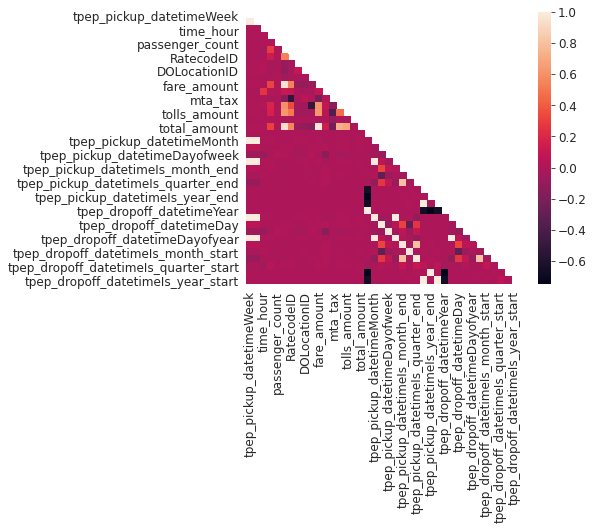

In [117]:
mask = np.zeros_like(corr) # Mask diagonal half of the heat map
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(7,5))
  ax = sns.heatmap(corr, mask=mask, vmax=1, square=True)

# Questions to data & extracting insights

##### **How much % of the total revenues do trips...**
- inside NYC
- to airports
- to outside of NYC **make up?** 

In [ ]:
rc_perc = round(df.groupby('RatecodeID').total_amount.sum() / df.groupby('RatecodeID').total_amount.sum().sum(), 4)
rc_perc

RatecodeID
1    0.8977
2    0.0864
3    0.0100
4    0.0015
5    0.0044
6    0.0000
Name: total_amount, dtype: float64

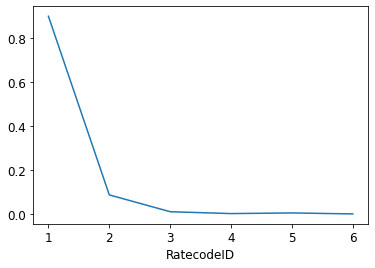

In [ ]:
rc_perc.plot()

##### **Of all rate codes, which one is the most efficient one in terms of revenues/spendings?**

Compute the efficiency by dividing `total_amount` by `trip_distance` for each rate code:

In [ ]:
revenues_eff = df.groupby('RatecodeID').total_amount.sum() / df.groupby('RatecodeID').trip_distance.sum()
revenues_eff

RatecodeID
1    5.859754
2    3.700279
3    5.504121
4    4.256652
5    8.496675
6    3.799629
dtype: float64

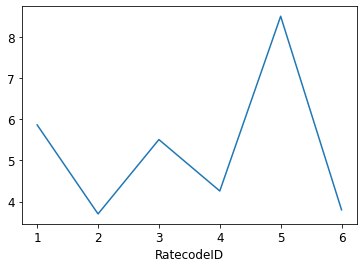

In [ ]:
revenues_eff.plot()

Answer: with group rides being an outlier, **negotiated fares** usually end up bringing the most bang for the buck. On contrary, trips to JFK turn out to be the least efficient. However, negotiated fares happen very seldom. Hence, **rides within the NYC** are a great trade-off between distance and revenues. 

***Note***: *Distance might be a bad proxy for expenses because fuel consumption tends to be much higher inside the city. A good next step would be to use the data of time and distance to predict the spendings on fuel and re-calculate the revenues/spendings relationship again.*

##### **What is the optimal car size?**

Car size will depend on passengers to take in. Let's find which amount of passengers is the most usual and brings the highest revenues.

In [ ]:
revn_by_pass = df.groupby('passenger_count').total_amount.sum() / df.groupby('passenger_count').total_amount.sum().sum()
revn_by_pass

passenger_count
1    0.710324
2    0.150266
3    0.042033
4    0.019640
5    0.048215
6    0.029508
7    0.000005
8    0.000005
9    0.000003
Name: total_amount, dtype: float64

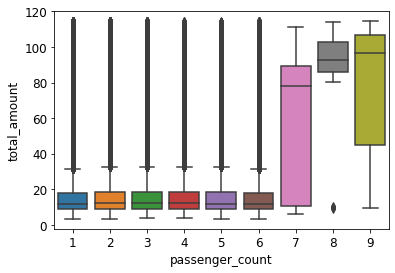

In [ ]:
sns.boxplot(x = 'passenger_count', y = 'total_amount', data = df)

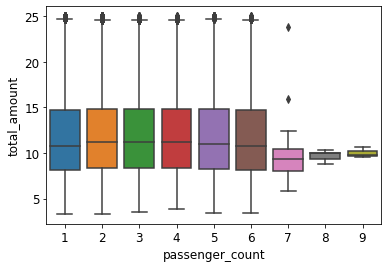

In [ ]:
sns.boxplot(x = 'passenger_count', y = 'total_amount', data = df[df['total_amount'] < 25])

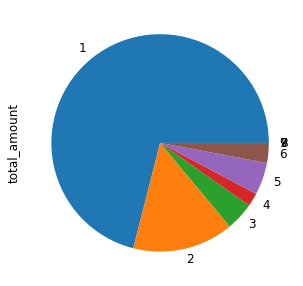

In [ ]:
revn_by_pass.plot.pie(y='total_amount', figsize=(5, 5))

Answer: The optimal car size is that takes in up to three people because rides with 1, 2, or 3 passengers make up over 90% of all the rides.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fafccb130b8>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fafcc359e80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fafcca648d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fafcc2b4ba8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fafcc2e6e10>, <matplotlib.axes._subplots.AxesSubplot object at 0x7fafcc2a30b8>], dtype=object)

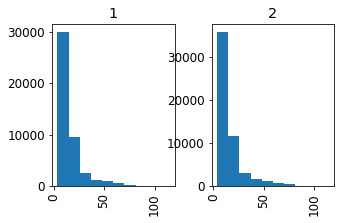

In [ ]:
df['total_amount'].hist(by=df['VendorID'], layout=(1,6), figsize=(16,3))

Seaborn data visualization etc.

##### **Insight**: Rides with one passenger and inside the city seem to be the most common thing to happen.

##### **Many rides seem to have only one passenger on board. How much revenues do these rides exactly make?**

In [92]:
df[(df['passenger_count'] == 1) & (df['RatecodeID'] == 1)].total_amount.sum() / df.total_amount.sum()

0.6427485379376562

**Answer**: 64%

**Idea**: What if taxis could be motorbikes? They are easier to drive in the city, consume less fuel and can take 1 person which would be enough for 64% of the rides!

##### **What are the busiest hours?**

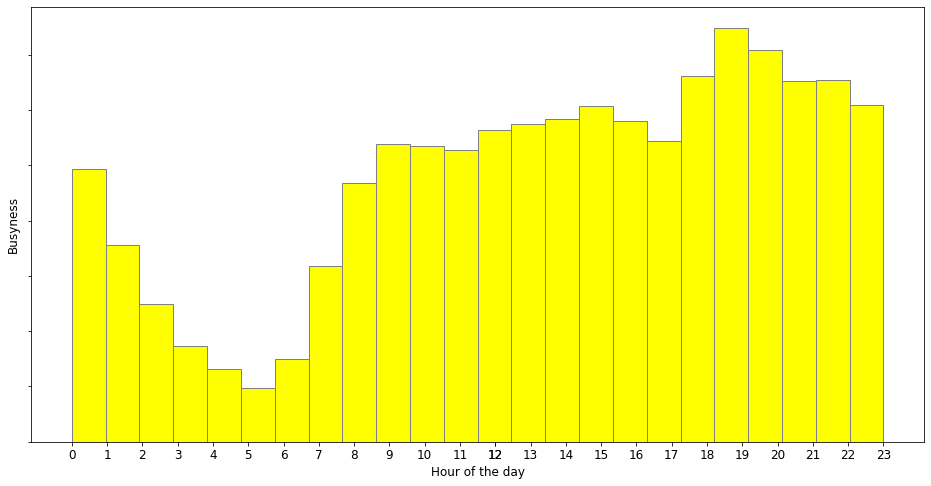

In [91]:
fig, ax = plt.subplots(figsize = (16,8))
counts, bins, patches = ax.hist(df['time_hour'], facecolor='yellow', edgecolor='gray', bins=24)
bins = np.array([math.floor(bin+0.5) for bin in bins])
ax.set_xticks(bins)
ax.set_ylabel('Busyness')
ax.set_xlabel('Hour of the day')
ax.set_yticklabels([])
plt.show()

**Answer**: 6 pm until 10 pm is the busiest time. The least busiest time is from 1 am until 8 am.

# Train the model

Here, we will develop an algorithm that can **suggest the tip amount** for taxi clients. I will go with RandomForests, supported by some nice features from `fastai` library.

Questions to answer:
- What influences the tip amount the most?
- What payment method brings most tips? (Except for cash because no data available)
- Does a particular day of the week influence the tip amount paid?
- Do people pay more tips at a particular time of the day?


Take a random subset of data to train the model.

In [93]:
df = df.sample(n=1000000, random_state=41) # 1,000,000 random samples

#### Convert raw dates into more insightful data with fastai

Instead of simply datetimes, we will have new features like day of the week, if it is a month end or beginning, etc. Hopefully, it will give us some more insights into the data.

In [95]:
df = add_datepart(df, 'tpep_pickup_datetime')

In [96]:
df = add_datepart(df, 'tpep_dropoff_datetime')

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 4242871 to 3425809
Data columns (total 43 columns):
 #   Column                                 Non-Null Count    Dtype   
---  ------                                 --------------    -----   
 0   VendorID                               1000000 non-null  category
 1   tpep_pickup_datetimeWeek               1000000 non-null  UInt32  
 2   tpep_dropoff_datetimeWeek              1000000 non-null  UInt32  
 3   time_hour                              1000000 non-null  int8    
 4   min_spent                              1000000 non-null  int16   
 5   passenger_count                        1000000 non-null  int8    
 6   trip_distance                          1000000 non-null  float64 
 7   RatecodeID                             1000000 non-null  int8    
 8   store_and_fwd_flag                     1000000 non-null  category
 9   PULocationID                           1000000 non-null  int64   
 10  DOLocationID            

In [98]:
df.columns

Index(['VendorID', 'tpep_pickup_datetimeWeek', 'tpep_dropoff_datetimeWeek',
       'time_hour', 'min_spent', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'tpep_pickup_datetimeYear', 'tpep_pickup_datetimeMonth',
       'tpep_pickup_datetimeDay', 'tpep_pickup_datetimeDayofweek',
       'tpep_pickup_datetimeDayofyear', 'tpep_pickup_datetimeIs_month_end',
       'tpep_pickup_datetimeIs_month_start',
       'tpep_pickup_datetimeIs_quarter_end',
       'tpep_pickup_datetimeIs_quarter_start',
       'tpep_pickup_datetimeIs_year_end', 'tpep_pickup_datetimeIs_year_start',
       'tpep_pickup_datetimeElapsed', 'tpep_dropoff_datetimeYear',
       'tpep_dropoff_datetimeMonth', 'tpep_dropoff_datetimeDay',
       'tpep_dropoff_datetimeDayofweek', 'tpep_dropoff_datetimeDayofyear',
       'tpep_d

In [99]:
dep_var = 'tip_amount'

In [100]:
procs = [Categorify, FillMissing]

In [101]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [102]:
cont,cat

(['trip_distance',
  'PULocationID',
  'DOLocationID',
  'fare_amount',
  'extra',
  'mta_tax',
  'tolls_amount',
  'improvement_surcharge',
  'total_amount',
  'tpep_pickup_datetimeYear',
  'tpep_pickup_datetimeMonth',
  'tpep_pickup_datetimeDay',
  'tpep_pickup_datetimeDayofweek',
  'tpep_pickup_datetimeDayofyear',
  'tpep_dropoff_datetimeYear',
  'tpep_dropoff_datetimeMonth',
  'tpep_dropoff_datetimeDay',
  'tpep_dropoff_datetimeDayofweek',
  'tpep_dropoff_datetimeDayofyear'],
 ['VendorID',
  'tpep_pickup_datetimeWeek',
  'tpep_dropoff_datetimeWeek',
  'time_hour',
  'min_spent',
  'passenger_count',
  'RatecodeID',
  'store_and_fwd_flag',
  'payment_type',
  'tpep_pickup_datetimeIs_month_end',
  'tpep_pickup_datetimeIs_month_start',
  'tpep_pickup_datetimeIs_quarter_end',
  'tpep_pickup_datetimeIs_quarter_start',
  'tpep_pickup_datetimeIs_year_end',
  'tpep_pickup_datetimeIs_year_start',
  'tpep_pickup_datetimeElapsed',
  'tpep_dropoff_datetimeIs_month_end',
  'tpep_dropoff_datetim

In [104]:
# relocate some columns that make more sense as continuous variables than categorical ones
cont.append('passenger_count') ; cat.remove('passenger_count')
cont.append('min_spent') ; cat.remove('min_spent')
cont.append('time_hour') ; cat.remove('time_hour')

In [105]:
# randomly split data into training and validation sets with 80% / 20% proportion
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [106]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [107]:
xs,y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs, to.valid.y

In [108]:
len(xs), len(valid_xs)

(800000, 200000)

In [109]:
to.show(3)

,VendorID,tpep_pickup_datetimeWeek,tpep_dropoff_datetimeWeek,RatecodeID,store_and_fwd_flag,payment_type,tpep_pickup_datetimeIs_month_end,tpep_pickup_datetimeIs_month_start,tpep_pickup_datetimeIs_quarter_end,tpep_pickup_datetimeIs_quarter_start,tpep_pickup_datetimeIs_year_end,tpep_pickup_datetimeIs_year_start,tpep_pickup_datetimeElapsed,tpep_dropoff_datetimeIs_month_end,tpep_dropoff_datetimeIs_month_start,tpep_dropoff_datetimeIs_quarter_end,tpep_dropoff_datetimeIs_quarter_start,tpep_dropoff_datetimeIs_year_end,tpep_dropoff_datetimeIs_year_start,tpep_dropoff_datetimeElapsed,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_datetimeYear,tpep_pickup_datetimeMonth,tpep_pickup_datetimeDay,tpep_pickup_datetimeDayofweek,tpep_pickup_datetimeDayofyear,tpep_dropoff_datetimeYear,tpep_dropoff_datetimeMonth,tpep_dropoff_datetimeDay,tpep_dropoff_datetimeDayofweek,tpep_dropoff_datetimeDayofyear,passenger_count,min_spent,time_hour,tip_amount
23506917,1,45,45,1,N,1,False,False,False,False,False,False,1510428981,False,False,False,False,False,False,1510429428,0.600000,107,90,6.000000,0.000000,0.500000,0.000000,0.300000,7.800000,2017,11,11,5,315,2017,11,11,5,315,1,7,20,1.000000
9469598,2,13,13,1,N,1,False,False,False,False,False,False,1490802106,False,False,False,False,False,False,1490803163,1.330000,186,161,12.000000,0.000000,0.500000,0.000000,0.300000,12.800000,2017,3,29,2,88,2017,3,29,2,88,1,17,16,0.000000
16376668,2,25,25,1,N,2,False,False,False,False,False,False,1498077981,False,False,False,False,False,False,1498078323,1.080000,236,141,6.000000,0.500000,0.500000,0.000000,0.300000,7.300000,2017,6,21,2,172,2017,6,21,2,172,5,5,21,0.000000


I will use Root Mean Squared Error as the metric

In [110]:
# create custom metrics
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [111]:
# create function to train a random forest regressor
def rf(xs, y, n_estimators=200, max_samples=200000, max_features=0.5, min_samples_leaf=5, **kwargs) :
  return RandomForestRegressor(n_jobs=-1,
                                n_estimators=n_estimators, # how many trees/models to train
                                max_samples=max_samples, # max amount of samples in the subset of data
                                max_features=max_features, # int(0.5*n_features)` features are considered at each split
                                min_samples_leaf=min_samples_leaf, # minimal amount of samples in one leaf node
                                oob_score=True).fit(xs, y)

In [112]:
# train
m = rf(xs, y);

In [113]:
# rmse on training and validation sets
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.305254, 0.326535)

#### Partial dependence: 
- Which payment method (except for cash because we have no data) brings most tips?
- Which rate code brings most tips?
- How does day of the week influence the `tip_amount`? (weekend = better mood = higher tips?)
- How does particular time influence the `tip_amount`? 
- How does `total_amount` influence the `tip_amount`? (expect  high influence here)

In [118]:
from sklearn.inspection import plot_partial_dependence

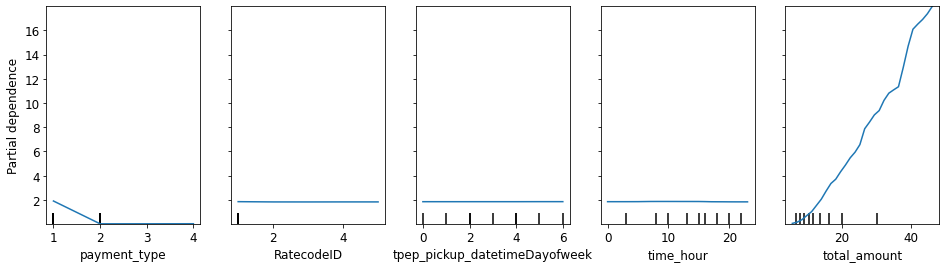

In [121]:
fig,ax = plt.subplots(figsize=(10, 20))
plot_partial_dependence(m, xs, ['payment_type', 'RatecodeID', 'tpep_pickup_datetimeDayofweek', 'time_hour', 'total_amount'],
                        n_cols=1, grid_resolution=30, ax=ax);

**Answers**: 
- Day of week, daytime as well as rate code all have **no importance** on `tip_amount` that customers pay.
- Payment method reflects that only credit card payments were properly recorded. We have no data for cash tips, so it's impossible to say for now whether it has an importancy.
- `total_amount` that customers pay has a **direct and almost linear influence** on the `tip_amount`.

Insights:  
1. For rides **under \$15** people pay around **\$0-2 tip**, then it starts rising.
2. Rate Codes from 2 to 5 turns out to be the most profitable ones.
- 1 = Standard Meter Fare = within city limit
- 2 = JFK = John F. Kennedy Airport
- 3 = Newark = Newark Airport
- 4 = Nassau or Westchester = Counties outside of NYC
- 5 = Negotiated fare
- 6 = Group ride

This makes sense because trips to airports normally are bigger distance trips

#### Feature importance & removing unimportant features

In [122]:
def rf_feat_importance(m, df, ascending=False):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=ascending)

In [123]:
fi = rf_feat_importance(m, xs, ascending=False)
fi[:15]

,cols,imp
28,total_amount,0.400648
5,payment_type,0.303398
23,fare_amount,0.182042
20,trip_distance,0.063473
26,tolls_amount,0.017819
40,min_spent,0.015302
3,RatecodeID,0.004718
24,extra,0.004648
22,DOLocationID,0.001541
41,time_hour,0.001385


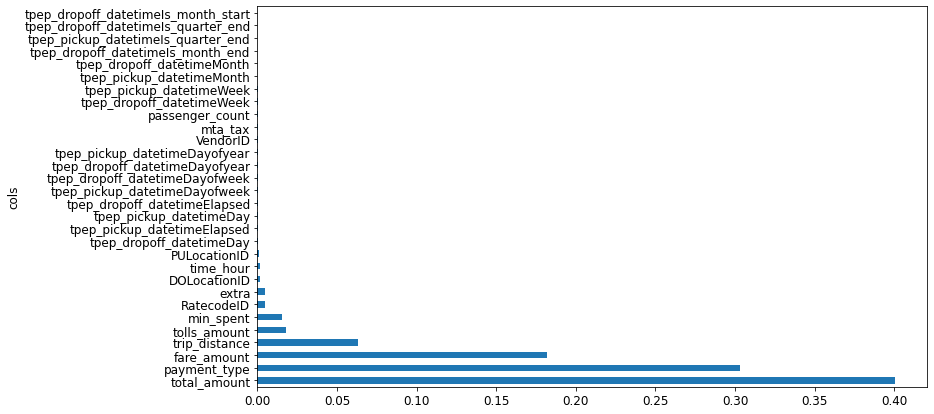

In [124]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [125]:
to_keep = fi[fi.imp>0.001].cols
len(to_keep)

10

In [126]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

Seems like some features are reduntant: fare, extras, taxes, etc. - they all add up to the `total_amount`. Let's try removing them.

#### Remove reduntant features

The fork pairs that are closer together to the right side are more identical with each other. 

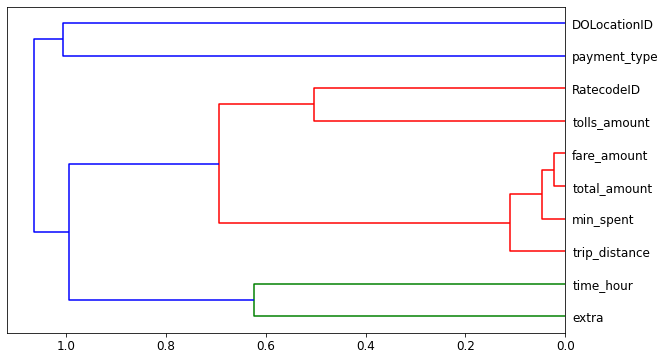

In [127]:
cluster_columns(xs_imp)

In [128]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=200000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

The OOB score ranges between 0 and 1, where 0 means that our model gives completely random answers, while 1 means that it is perfectly accurate.  

In [129]:
# our baseline
get_oob(xs_imp)

0.9703209381652628

Remove similar features one by one and see how it impacts the performance of the model:

In [130]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in ('fare_amount', 'extra', 'tolls_amount', 'total_amount')}
# 'tpep_dropoff_datetimeDayofyear', 'tpep_dropoff_datetimeWeek', 'tpep_dropoff_datetimeElapsed', 'tpep_dropoff_datetimeDay', 'tpep_dropoff_datetimeDayofweek', 'mta_tax' 

{'extra': 0.9651085630571686,
 'fare_amount': 0.9392283805152429,
 'tolls_amount': 0.9511226787233948,
 'total_amount': 0.7703855826952121}

Seems that without the information about the `total_amount`, we lose a lot of prediction accuracy. What if we drop everything that adds up to the `total_amount`?

In [131]:
# without components of total_amount
get_oob(xs_imp.drop(['fare_amount', 'extra', 'tolls_amount'], axis=1))

0.9251890714852284

Seems like we're losing a lot of performance with this move. This does not seem to be a good idea and we will not drop anything more.

Let's retrain our model (with only 10 features now)

In [135]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.296005, 0.313102)

#### Re-calculate feature importance

In [166]:
fi = rf_feat_importance(m, xs_imp, ascending=False)

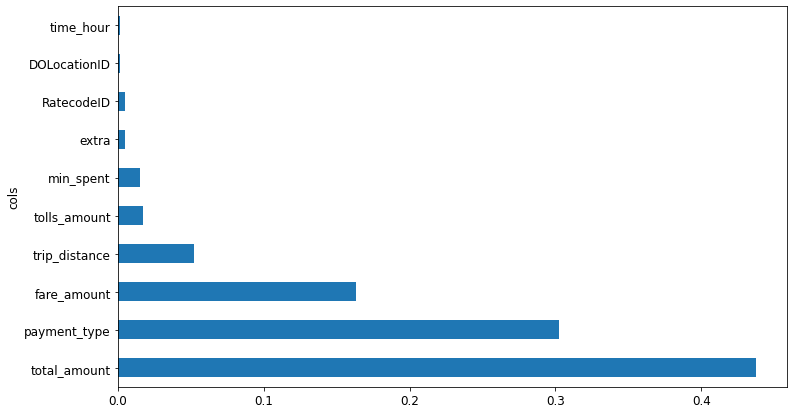

In [168]:
plot_fi(fi[:]);

### Model interpretation and use in production

In [143]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [144]:
row = valid_xs_imp.iloc[:5]

In [145]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

Let's take one  example (the third one here) and try to interpret what exactly happened

In [164]:
row.iloc[[2]] # this is how the sample looks like

,total_amount,payment_type,fare_amount,trip_distance,tolls_amount,min_spent,RatecodeID,extra,DOLocationID,time_hour
23073284,17.879999,1,13.500000,1.720000,0.000000,20,1,0.000000,239,15


In [165]:
# predicted tip,  starting point, contributions from features
  prediction[2],  bias[2],        contributions[2]

(array([3.58274486]),
 1.8511081963967597,
 array([ 0.54519444,  0.71841802,  0.27501193, -0.04875542, -0.00761575,  0.11405678,  0.        ,  0.09943332,  0.00546845,  0.03042489]))

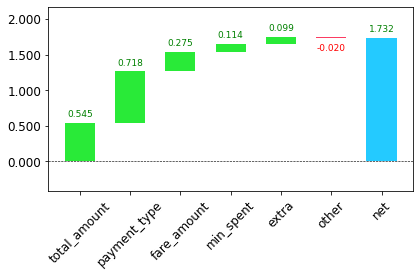

In [154]:
waterfall(valid_xs_imp.columns, contributions[2], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

1. The model's `bias` is at \$1.85. It means that it initially starts the prediction at the level of \$1.85 and then adds up contributions from different features. Contributions can be positive or negative.
2. In this example, the **predicted tip is \$3.58**.
3. It **started from** the bias level of **\$1.85**, the `total_amount` **added \$0.54** to the tip, `payment_type` (which is by credit card in this example) **added \$0.72** to the total tip amount.

This information would be very useful in production because it offers high explainability as to how exactly the algorithm made its prediction. 